## Speech Emotion Recognition Project

---
For this task, I have used 2452 samples from

# the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset:

1440 *speech files and *1012 Song files from RAVDESS. This dataset includes recordings of 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each file was rated 10 times on emotional validity, intensity, and genuineness.






In [1]:
import librosa
import soundfile
import os, glob,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
audio_file = '03-01-03-01-01-01-01.wav'
librosa_audio_data,librosa_sample_rate = librosa.load(audio_file,sr=2200)

In [ ]:
print(librosa_audio_data)

[ 4.2266457e-08 -4.1529699e-08  3.8412889e-08 ...  5.8208087e-08
  3.1396321e-09  0.0000000e+00]


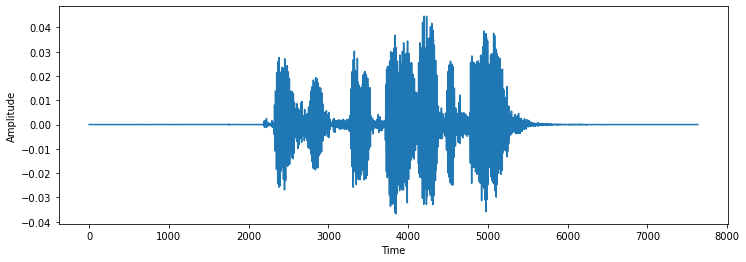

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(librosa_audio_data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
mfccs= librosa.feature.mfcc(y=librosa_audio_data,sr= librosa_sample_rate,n_mfcc=40)
print(mfccs.shape)

(40, 15)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_folder = "/content/drive/MyDrive/Speech_emotion_dataset"
os.listdir(data_folder)

['Actor_17',
 'Actor_24',
 'Actor_20',
 'Actor_15',
 'Actor_22',
 'Actor_23',
 'Actor_18',
 'Actor_19',
 'Actor_21',
 'Actor_16',
 'Actor_13',
 'Actor_05',
 'Actor_09',
 'Actor_10',
 'Actor_07',
 'Actor_08',
 'Actor_12',
 'Actor_06',
 'Actor_14',
 'Actor_11',
 'Actor_02',
 'Actor_03',
 'Actor_01',
 'Actor_04']

In [4]:
emotions = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
classes = {
  'calm':'calm',
  'happy':'happy',
  'sad':'sad',
  'angry':'angry',
  'fearful':'fearful',
  'surprised':'surprised'
}
unobserved_emotions = ['neutral', 'disgust']


In [5]:
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [6]:
def extract_feature(file_name, mfcc, mel):
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype = "float32")          # read sound as float
    X = noise(X)
    sample_rate = sound_file.samplerate
    result = np.array([])
    if mfcc:
      mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 30).T, axis = 0)
      result = np.hstack((result, mfccs))     # create matrix
    
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

In [7]:
def load_data(test_size = 0.2):
  x,y = [],[]
  for file in glob.glob(data_folder+"/Actor_*/*.wav"):
      file_name = os.path.basename(file)
      emotion = emotions[file_name.split("-")[2]]
      if emotion in unobserved_emotions:
          continue
      feature = extract_feature(file, mfcc = True, mel= False)
      x.append(feature)
      y.append(emotion)
  return train_test_split(np.array(x), y, test_size = test_size, random_state = 9)

## Train Test Spliting

---



In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = load_data(test_size = 0.20)

In [ ]:
x_train.shape

(931, 30)

In [ ]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(931, 233)
Features extracted: 30


## Selecting a model classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(alpha = 0.01, batch_size = 32, hidden_layer_sizes = (64,32,32,16,8), learning_rate = 'adaptive', max_iter = 215)


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(colsample_bytree=0.2, gamma=0.0468, 
                             learning_rate=0.1, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=100,
                             reg_alpha=0.4640, reg_lambda=1.25,
                             subsample=0.2, silent=0,
                             random_state =7, nthread = -1)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (215) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 39.91%


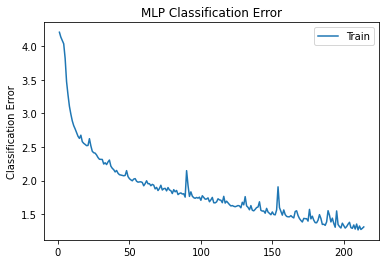

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
MLP.fit(x_train, y_train)
train_pred = MLP.predict(x_test)
# Evaluate Predictions
accuracy = accuracy_score(y_test, train_pred)
print("accuracy: %.2f%%" % (accuracy*100))
#Get Results
x_axis = range(0, MLP.n_iter_)
fig, ax = plt.subplots()
ax.plot(x_axis, MLP.loss_curve_, label='Train')
ax.legend()
plt.ylabel('Classification Error')
plt.title('MLP Classification Error')
plt.show()

[0]	validation_0-merror:0.657358	validation_1-merror:0.716738
[1]	validation_0-merror:0.575725	validation_1-merror:0.639485
[2]	validation_0-merror:0.533835	validation_1-merror:0.613734
[3]	validation_0-merror:0.497315	validation_1-merror:0.613734
[4]	validation_0-merror:0.489796	validation_1-merror:0.639485
[5]	validation_0-merror:0.462943	validation_1-merror:0.630901
[6]	validation_0-merror:0.47261	validation_1-merror:0.643777
[7]	validation_0-merror:0.450054	validation_1-merror:0.635193
[8]	validation_0-merror:0.422127	validation_1-merror:0.613734
[9]	validation_0-merror:0.413534	validation_1-merror:0.596566
[10]	validation_0-merror:0.411386	validation_1-merror:0.596566
[11]	validation_0-merror:0.387755	validation_1-merror:0.587983
[12]	validation_0-merror:0.389903	validation_1-merror:0.587983
[13]	validation_0-merror:0.396348	validation_1-merror:0.575107
[14]	validation_0-merror:0.382385	validation_1-merror:0.553648
[15]	validation_0-merror:0.373792	validation_1-merror:0.540773
[16

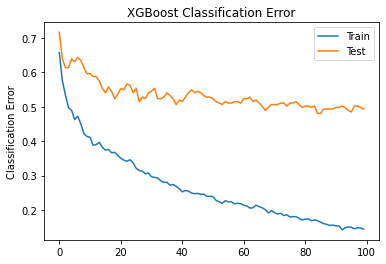

In [ ]:
import matplotlib.pyplot as plt
eval_set = [(x_train, y_train), (x_test, y_test)]
xgb.fit(x_train, y_train, eval_metric=["merror"], eval_set=eval_set, verbose=True)
train_pred = xgb.predict(x_test)
# Evaluate Predictions
accuracy = accuracy_score(y_test, train_pred)
print("accuracy: %.2f%%" % (accuracy*100))
#Get Results
results = xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dtree_pred = dtree.predict(x_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,dtree_pred))

              precision    recall  f1-score   support

       angry       0.50      0.42      0.45        36
        calm       0.52      0.41      0.46        39
     fearful       0.32      0.27      0.29        41
       happy       0.17      0.25      0.21        32
         sad       0.26      0.28      0.27        40
   surprised       0.40      0.44      0.42        45

    accuracy                           0.35       233
   macro avg       0.36      0.34      0.35       233
weighted avg       0.37      0.35      0.35       233



In [ ]:
accuracy = accuracy_score(y_test,dtree_pred)
print("Accuracy is:%.2f%% "% (accuracy*100))

Accuracy is:34.76% 


In [ ]:
mlp_pred = MLP.predict(x_test)
xgb_pred = xgb.predict(x_test)

In [ ]:
xgb_pred[79]

'surprised'

In [ ]:
train_xg = xgb.predict(x_train)
train_mlp = MLP.predict(x_train)

In [ ]:
from sklearn.metrics import classification_report
print("xgb: {}".format(classification_report(y_test, xgb_pred, target_names=classes)))
print("mlp: {}".format(classification_report(y_test, mlp_pred, target_names=classes)))

ValueError: ignored

In [ ]:
#Printing the accuracy
accuracy = accuracy_score(y_true = y_test, y_pred = mlp_pred)
print("Accuracy for mlp: {:.2f}%".format(accuracy*100))
accuracy = accuracy_score(y_true = y_test, y_pred = xgb_pred)
print("Accuracy for xgBoost: {:.2f}%".format(accuracy*100))

Accuracy for mlp: 45.92%
Accuracy for xgBoost: 50.64%


In [ ]:
#1D CNN
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import losses, models, optimizers
from keras.activations import relu, softmax

In [ ]:
# Preparation steps to get it into the correct format for Keras 
X_train = np.array(x_train)
y_train = np.array(y_train)
X_test = np.array(x_test)
y_test = np.array(y_test)

# One hot encode the target
from sklearn.preprocessing import LabelEncoder 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(931, 30)
['angry' 'calm' 'fearful' 'happy' 'sad' 'surprised']


In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape
#Dimension preps for 1D CNN

(931, 30, 1)

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(6)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 256)           2304      
_________________________________________________________________
activation (Activation)      (None, 30, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 256)           524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 256)            0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Train
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=128, epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
8/8 [==============================] - 7s 553ms/step - loss: 1.7387 - accuracy: 0.2828 - val_loss: 1.7721 - val_accuracy: 0.1674
Epoch 2/100
8/8 [==============================] - 4s 459ms/step - loss: 1.7374 - accuracy: 0.2790 - val_loss: 1.7708 - val_accuracy: 0.1674
Epoch 3/100
8/8 [==============================] - 4s 467ms/step - loss: 1.7346 - accuracy: 0.2932 - val_loss: 1.7692 - val_accuracy: 0.1717
Epoch 4/100
8/8 [==============================] - 4s 462ms/step - loss: 1.7322 - accuracy: 0.2839 - val_loss: 1.7670 - val_accuracy: 0.1803
Epoch 5/100
8/8 [==============================] - 4s 459ms/step - loss: 1.7313 - accuracy: 0.2624 - val_loss: 1.7649 - val_accuracy: 0.1888
Epoch 6/100
8/8 [==============================] - 4s 463ms/step - loss: 1.7218 - accuracy: 0.2776 - val_loss: 1.7626 - val_accuracy: 0.2017
Epoch 7/100
8/8 [==============================] - 4s 463ms/step - loss: 1.7216 - accuracy: 0.2838 - val_loss: 1.7604 - val_accuracy: 0.2103
Epoch 8/100
8

accuracy: 33.05%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


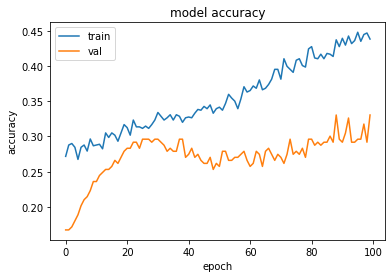

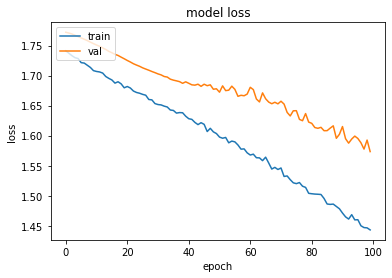

In [ ]:
#Predict
import matplotlib.pyplot as plt
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

print(model_history.history.keys())

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Save Model 
model_name = 'Emotion_Model-1D-CNN.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model-1D-CNN.h5 


In [ ]:
preds = model.predict(X_test, batch_size=16,verbose=1)

preds=preds.argmax(axis=1)

15/15 [==============================] - 1s 8ms/step


In [ ]:
preds1 = preds.astype(int).flatten()
preds1 = (lb.inverse_transform((preds1)))
actual= y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))

In [ ]:
#Print Confusion Matrix
print(classification_report(actual, preds1, target_names=classes))

              precision    recall  f1-score   support

        calm       0.28      0.78      0.41        36
       happy       0.52      0.67      0.58        39
         sad       0.47      0.17      0.25        41
       angry       0.11      0.06      0.08        32
     fearful       0.18      0.12      0.15        40
   surprised       0.39      0.20      0.26        45

    accuracy                           0.33       233
   macro avg       0.33      0.33      0.29       233
weighted avg       0.33      0.33      0.29       233



In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(actual, preds1)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[28  0  1  3  1  3]
 [ 0 26  0  0 13  0]
 [19  3  7  6  4  2]
 [18  2  3  2  3  4]
 [ 8 16  3  3  5  5]
 [26  3  1  4  2  9]]


In [ ]:
y_pred = MLP.predict(x_test)

In [ ]:
y_pred[5]

'surprised'